In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
from scipy.stats import linregress
import glob
import pickle

#importing notebook gui library
import ipywidgets as widgets
from ipywidgets.widgets import Label, FloatSlider, Button, IntSlider
from ipywidgets import Layout, HBox, VBox
from IPython.display import display
from ipywidgets import interact
import time
from matplotlib.widgets import Slider, Button

%matplotlib inline

# Advanced Lane Line

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.

## Calibrate camera

In [2]:
nx = 9
ny = 6

images = glob.glob('./camera_cal/calibration*.jpg')
images.sort()
# print(images[3])
# images = [images[3]]

objpoints = []
imgpoints =[]

objp = np.zeros((ny*nx, 3), np.float32)
objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)

# Calibrate images in camera_cal\
for i, fname in enumerate(images):
    # Generate output filename 
    savfname = "{}{}{}.jpg".format('./camera_cal_output/',(fname.split(sep='/')[-1]).split(sep='.')[0], "_points")
    
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

    if ret == True:
        # Found cornders
        objpoints.append(objp)
        imgpoints.append(corners)
        
        # Draw on image and save 
        cv2.drawChessboardCorners(img, (nx, ny), corners, ret)
        cv2.imwrite(savfname, img)


# Caculate calibration coefficient from all images have points.
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
        
# Correct images found  and save as "_cal_output"
for fname in images:
    savfname = "{}{}{}.jpg".format('./camera_cal_output/',(fname.split(sep='/')[-1]).split(sep='.')[0], "_cal")
    img = cv2.imread(fname)
    undist = cv2.undistort(img, mtx, dist, None, mtx)  
    cv2.imwrite(savfname, undist)

In [3]:
def cali_image(img, nx=9, ny=6):

    objp = np.zeros((ny*nx, 3), np.float32)
    objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)

    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
    
    rtn = None
    
    if ret == True:
        rtn = (objp, corners)

        return rtn    
    else:
        pass


def cali_images(filelist):
    
    objpoints = []
    imgpoints = []
    
    for fname in filelist:
        img = cv2.imread(fname)
#         print(fname)
        
        try:
            objp, imgp = cali_image(img)
            objpoints.append(objp)
            imgpoints.append(imgp)
            
        except:
            print('Cannot find corners: {}'.format(fname))
    
    return (objpoints, imgpoints)
        

def cali_undistort(ref, objpoints, imgpoints):
    '''
    img:  image object
    objpoints:  list
    imgpoints:  list
    
    Calibrate and return undistorted image
    
    Return:  undistorted image
    '''
    
    if type(ref) is str:
        img = cv2.imread(ref)
    elif len(ref.shape) == 3:
        img = ref
    
    # Caculate calibration coefficient from all images have points.
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    undist = cv2.undistort(img, mtx, dist, None, mtx)  
#     plt.imshow(img)
    
    return undist

In [4]:
path = glob.glob('./camera_cal/calibration*.jpg')
objpoints, imgpoints = cali_images(path)

Cannot find corners: ./camera_cal/calibration5.jpg
Cannot find corners: ./camera_cal/calibration4.jpg
Cannot find corners: ./camera_cal/calibration1.jpg


In [5]:
img1=cali_undistort('./camera_cal/calibration1.jpg', objpoints, imgpoints)
img2=cali_undistort('./camera_cal/calibration2.jpg', objpoints, imgpoints)
img3=cali_undistort('./camera_cal/calibration3.jpg', objpoints, imgpoints)

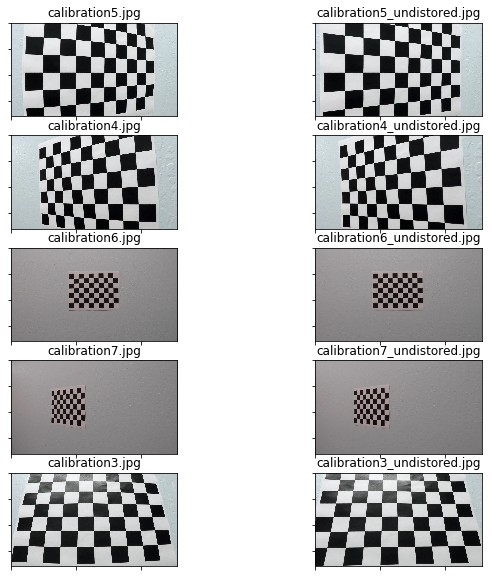

In [6]:
examples=path[:5]
nimg = len(examples)

fig, axes= plt.subplots(ncols=2, nrows=int(nimg))
fig.set_figheight(10)
fig.set_figwidth(10)
# fig.

for i, tmp in enumerate(examples):
    axes[i, 0].imshow(cv2.imread(tmp))
    axes[i, 0].set_title("{}.jpg".format(tmp.split(sep="/")[2].split('.')[0]))
    axes[i, 0].set_xticklabels([])
    axes[i, 0].set_yticklabels([])
    axes[i, 1].imshow(cali_undistort(tmp, objpoints, imgpoints))
    axes[i, 1].set_title("{}_undistored.jpg".format(tmp.split(sep="/")[2].split('.')[0]))
    axes[i, 1].set_xticklabels([])
    axes[i, 1].set_yticklabels([])
fig.savefig("./camera_cal_output/before_after_undistorted.jpg")

## Lane Detection Pipeline

* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

### Test Images

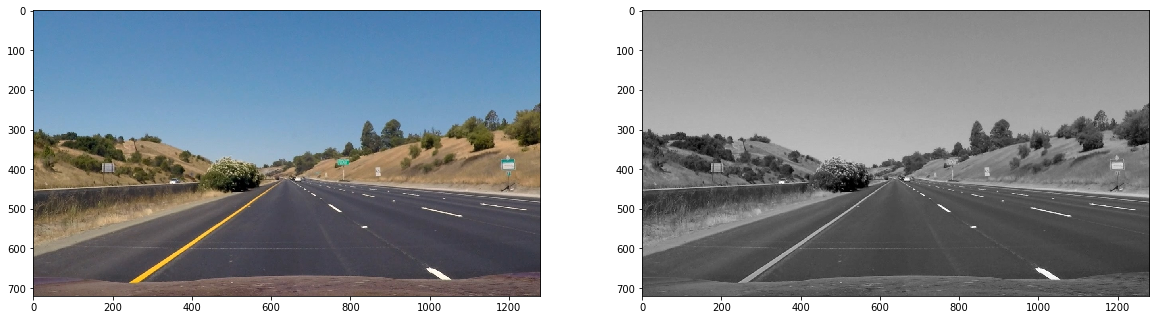

In [7]:
image = cv2.imread('./test_images/straight_lines1.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

fig, (ax1, ax2) = plt.subplots(ncols=2, nrows=1)
fig.set_size_inches(h=10,w=20)
ax1.imshow(image)
ax2.imshow(gray, 'gray')

## Color and Gradient/Sobel Filtering

In [8]:
def hls_filter(img, ch='h', th=None):
    ch_no = 0
    hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
    
    if ch == 'h':
        ch = np.zeros_like(hls[:,:,0])
        ch_no=0
    elif ch == 'l':
        ch = np.zeros_like(hls[:,:,1])
        ch_no=1
    elif ch == 's':
        ch = np.zeros_like(hls[:,:,2])
        ch_no=2
    else:
        raise
    
    ch[(hls[:,:,ch_no]>=th[0]) & (hls[:,:,ch_no]<=th[1])] = 1
    
    binary = np.zeros_like(ch)
#     binary[(h==1) | (l==1) | (s==1)] = 1
    binary[(ch==1)] = 1
    
    return ch
    

def sobel_filter(img, direction='x', bin_th=None, kernal_size=3, ):
    '''
    img:  image array as np.array
    binary: default return array. optional return binary array 
    binary_th_max, binary_th_min: filter threshold for binary array
    return np.array
    '''
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    if direction == 'x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    elif direction == 'y':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1)
    else:
        raise 
    
    sobel_abs = np.absolute(sobel)
    sobel_scaled = np.uint8(255*sobel_abs / np.max(sobel_abs)) 
    
    sobel_binary = np.zeros_like(sobel_scaled)

    if bin_th is None:
        return sobel_scaled
    elif type(bin_th) is tuple:
        sobel_binary[(sobel_scaled >= bin_th[0]) & (sobel_scaled <= bin_th[1])] = 1
        return sobel_binary
    else:
        raise
    
def sobel_y(img, bin_th=None, kernal_size=3, ):
    '''
    img:  image array as np.array
    binary: default return array. optional return binary array 
    bin_th: tuple, filter min/max threshold for binary array
    return np.array
    '''
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=kernal_size)
    sobely_abs = np.absolute(sobely)
    sobely_scaled = np.uint8(255*sobely_abs / np.max(sobely_abs)) 
    
    sobely_binary = np.zeros_like(sobely_scaled)
    if bin_th is None:
        return sobely_scaled
    elif type(bin_th) is tuple:
        sobely_binary[(sobely_scaled >= bin_th[0]) & (sobely_scaled <= bin_th[1])] = 1
        return sobely_binary
    else:
        raise
        

def gradient_mag(img, th=(0,255), kernal_size=3):
     
    sbx = sobel_filter(img, 'x', kernal_size=kernal_size)
    sby = sobel_filter(img, 'y', kernal_size=kernal_size)
    
    sbxy = np.sqrt(sbx**2 + sby**2)
    sbxy_scaled = np.uint8(255*sbxy / np.max(sbxy))
    
    if th is None:
        return sbxy_scaled
    elif type(th) is tuple:
        binary = np.zeros_like(sbxy_scaled)
        binary[(sbxy_scaled >= th[0]) & (sbxy_scaled <= th[1])] = 1
        return binary
    else:
        raise



def gradient_dir(img, th=(0, np.pi/2), kernal_size=3):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=kernal_size)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=kernal_size)

    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    
    binary =  np.zeros_like(absgraddir)
    binary[(absgraddir >= th[0]) & (absgraddir <= th[1])] = 1
    
    return binary

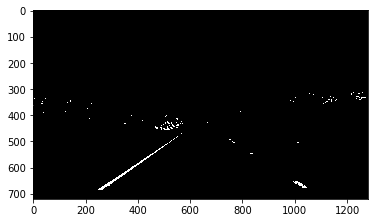

In [9]:
plt.imshow(hls_filter(image, 's', th=(200, 255)), cmap='gray')

### GUI

Use GUI sliders from `ipywidgets` libarary to fine tune thresholds each filter.

#### Establish slider objects:

In [10]:
sbx_l_slider = widgets.IntSlider(
    value=0,
    min=0,
    max=255,
    step=1
)
sbx_h_slider = widgets.IntSlider(
    value=255,
    min=0,
    max=255,
    step=1
)
sby_l_slider = widgets.IntSlider(
    value=0,
    min=0,
    max=255,
    step=1
)
sby_h_slider = widgets.IntSlider(
    value=255,
    min=0,
    max=255,
    step=1
)
mag_l_slider = widgets.IntSlider(
    value=0,
    min=0,
    max=255,
    step=1
)
mag_h_slider = widgets.IntSlider(
    value=255,
    min=0,
    max=255,
    step=1
)
dir_l_slider = widgets.FloatSlider(
    value=0,
    min=np.pi/180*0,
    max=np.pi/180*90,
    step=np.pi/180
)
dir_h_slider = widgets.FloatSlider(
    value=np.pi/180*90,
    min=np.pi/180*1,
    max=np.pi/180*90,
    step=np.pi/180
)
s_l_slider = widgets.IntSlider(
    value=255,
    min=0,
    max=255,
    step=1
)
s_h_slider = widgets.IntSlider(
    value=255,
    min=0,
    max=255,
    step=1
)



#### Read all test images

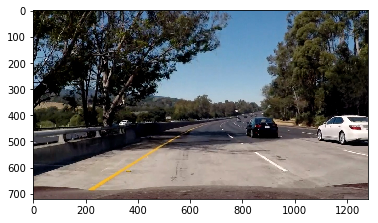

In [11]:
f = glob.glob('./test_images/*.jpg')
f.sort()
gui_images = []
for i, path in enumerate(f): 
#     print(path)
    gui_images.append(cv2.imread(path))

plt.imshow(cv2.cvtColor(gui_images[6], cv2.COLOR_BGR2RGB))

#### Run GUI
GUI calls `update` function when sliders are changed.

GUI plots all 8 test images side-by-side, this helps to determine the best thresholds various of road conditionds.

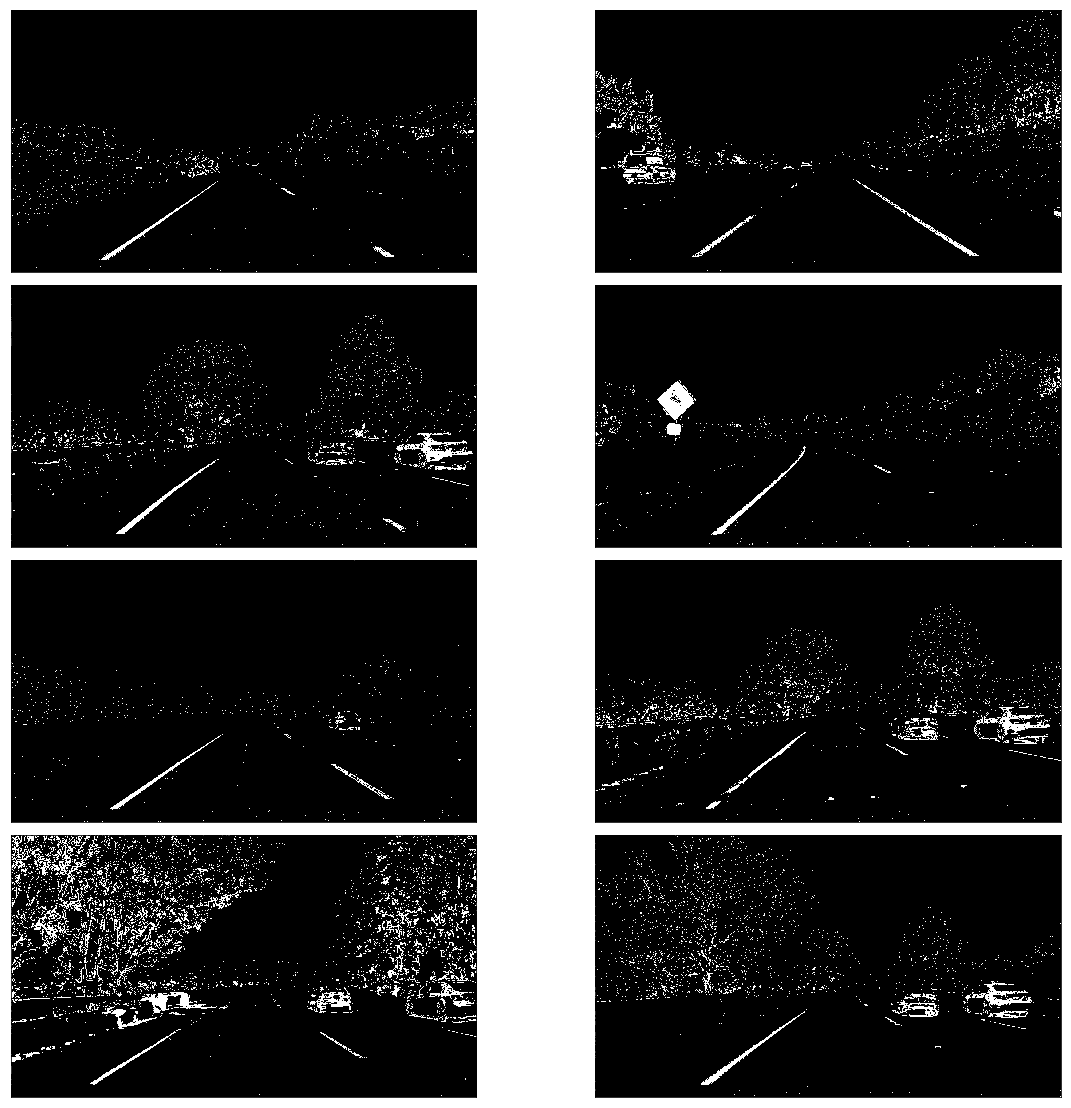

In [12]:
def update(s1=sbx_l_slider, s2=sbx_h_slider, s3=sby_l_slider, s4=sby_h_slider, \
           s5=mag_l_slider, s6=mag_h_slider, \
           s7=dir_l_slider, s8=dir_h_slider, \
           s9=s_l_slider, s10=s_h_slider):
    
    fig, axes = plt.subplots(ncols=2, nrows=int(len(gui_images)/2))
#     fig.set_dpi(300)
    fig.set_size_inches(h=20, w=20)
#     fig.set_size_inches(h=20, w=10)
    plt.subplots_adjust(wspace=0.1, hspace=0.05)
    for i, gui_image in enumerate(gui_images):
        gx = sobel_filter(gui_image, bin_th=(s1, s2))
        gy = sobel_filter(gui_image, bin_th=(s3, s4))

        gmag = gradient_mag(gui_image, th=(s5,s6))

        gdir = gradient_dir(gui_image, th=(s7, s8)) 
        
        s_ch = hls_filter(gui_image, 's' , (s9, s10))

        combined = np.zeros_like(gmag)
        combined[((gx==1) & (gy==1)) | ((gmag==1) & (gdir==1)) | (s_ch==1)] = 1
    
        axes.reshape(-1)[i].imshow(combined, 'gray')
        axes.reshape(-1)[i].set_xticks([])
        axes.reshape(-1)[i].set_yticks([])


interact(update)

### Finalize threshold settings from GUI
Once satisfied with the fine tuning, below is the finalized thresholds setting.

Note from fine tuning: 

- Gradient magnitude `gmag` and saturation channel `s_ch` thresholds are at the higher end
- sobel x `gx` does not have much impact enhancing the lanes

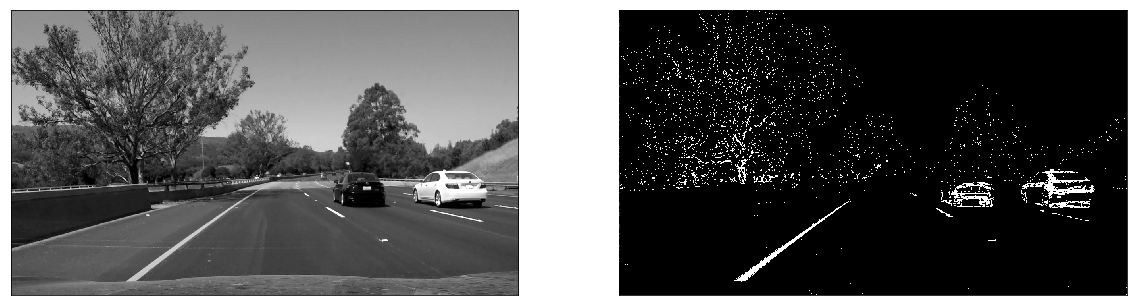

In [36]:
image = gui_images[7]
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

gx = sobel_filter(image, bin_th=(100, 150))
gy = sobel_filter(image, bin_th=(20, 150))
# gy = gx
gmag = gradient_mag(image, th=(220,250))
# gmag = np.zeros_like(gx)
gdir = gradient_dir(image, th=(0.07, 0.26)) 
s_ch = hls_filter(image, 's', th=(180,255))

# gdir = np.zeros_like(gx)
combined = np.zeros_like(gmag)
combined[((gx==1) & (gy==1)) | ((gmag==1) & (gdir==1)) | (s_ch==1)] = 1

fig, (ax1, ax2) = plt.subplots(ncols=2, nrows=1)
fig.set_size_inches(h=10,w=20)
ax1.imshow(gray, cmap='gray')
ax2.imshow(combined, 'gray')
ax1.tick_params(axis='both', labelbottom=False, bottom=False, left=False, labelleft=False)
ax2.tick_params(axis='both', labelbottom=False, bottom=False, left=False, labelleft=False)

## Top View Transformation